<a href="https://colab.research.google.com/github/cesphamm/procesamiento_lenguaje_natural/blob/main/Desafio_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">

# Procesamiento de lenguaje natural
## Desafío 3: Modelo de lenguaje con tokenización por caracteres

**Alumna:** Carla Espínola Hamm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import urllib.request
import bs4 as bs

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.utils import pad_sequences

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.19.0
Keras version: 3.10.0


In [ ]:
# Configuración de GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"\nGPU detectada: {len(gpus)} dispositivo(s)")
    for gpu in gpus:
        print(f"   • {gpu.name}")

    # Habilitar crecimiento dinámico de memoria
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

else:
    print("\nNo se detectó GPU.")


GPU detectada: 1 dispositivo(s)
   • /physical_device:GPU:0


## 1. Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje

Ekegí la Odisea de Homero porque con Don Quijote se me moría el notebook por timeout cuando estaba ejecutando el segundo train.

In [ ]:
#url = 'https://www.textos.info/miguel-de-cervantes-saavedra/el-ingenioso-hidalgo-don-quijote-de-la-mancha/ebook'
url = 'https://www.textos.info/homero/odisea/ebook'
raw_html = urllib.request.urlopen(url)
raw_html = raw_html.read()

# Parsear artículo. 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

# Concatenar el texto de todos los párrafos
corpus = ''
for para in article_paragraphs:
    corpus += para.text + ' '

# Pasar todo el texto a minúscula
corpus = corpus.lower()

print(f"Longitud total del corpus: {len(corpus):,} caracteres")
print(f"\nPrimeros 500 caracteres del corpus:")
print("-" * 50)
print(corpus[:500])

Longitud total del corpus: 681,633 caracteres

Primeros 500 caracteres del corpus:
--------------------------------------------------
 háblame, musa, de aquel varón de multiforme ingenio que, después de 
destruir la sacra ciudad de troya, anduvo peregrinando larguísimo 
tiempo, vio las poblaciones y conoció las costumbres de muchos hombres y
 padeció en su ánimo gran número de trabajos en su navegación por el 
ponto, en cuanto procuraba salvar su vida y la vuelta de sus compañeros a
 la patria. mas ni aun así pudo librarlos, como deseaba, y todos 
perecieron por sus propias locuras. ¡insensatos! comiéronse las vacas de
 helios


## 2. Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

In [ ]:
# Definir tamaño de contexto
MAX_CONTEXT_SIZE = 100

In [ ]:
# Crear vocabulario de caracteres únicos
chars_vocab = sorted(set(corpus))
vocab_size = len(chars_vocab)

print(f"Tamaño del vocabulario: {vocab_size} caracteres únicos")
print(f"\nCaracteres en el vocabulario:")
print(chars_vocab)

Tamaño del vocabulario: 58 caracteres únicos

Caracteres en el vocabulario:
['\t', '\n', ' ', '!', '"', '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '¡', '¿', 'á', 'é', 'í', 'ñ', 'ó', 'ú', 'ü', '—']


In [ ]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {ch: idx for idx, ch in enumerate(chars_vocab)}
idx2char = {idx: ch for ch, idx in char2idx.items()}

print("🔗 Ejemplos de mapeo char2idx:")
for ch in ['a', 'e', 'i', 'o', 'u', ' ', '.']:
    if ch in char2idx:
        print(f"  '{ch}' -> {char2idx[ch]}")

🔗 Ejemplos de mapeo char2idx:
  'a' -> 24
  'e' -> 28
  'i' -> 32
  'o' -> 37
  'u' -> 43
  ' ' -> 2
  '.' -> 9


In [ ]:
# Tokenizar el corpus completo
tokenized_corpus = np.array([char2idx[ch] for ch in corpus], dtype=np.int32)

print(f"Corpus tokenizado - shape: {tokenized_corpus.shape}")
print(f"\nPrimeros 50 tokens:")
print(tokenized_corpus[:50])

Corpus tokenizado - shape: (681633,)

Primeros 50 tokens:
[ 2 31 50 25 34 24 35 28  7  2 35 43 41 24  7  2 27 28  2 24 39 43 28 34
  2 44 24 40 54 36  2 27 28  2 35 43 34 42 32 29 37 40 35 28  2 32 36 30
 28 36]


### Estructuración del Dataset

In [ ]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `MAX_CONTEXT_SIZE` que se usará en validación
p_val = 0.1
#num_val = int(np.ceil(len(tokenized_corpus)*p_val/MAX_CONTEXT_SIZE))
split_idx = int(len(tokenized_corpus) * (1 - p_val))

# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_corpus = tokenized_corpus[:split_idx]
val_corpus = tokenized_corpus[split_idx:]

print(f"📊 División del corpus:")
print(f"  • Entrenamiento: {len(train_corpus):,} caracteres ({len(train_corpus)/len(tokenized_corpus)*100:.1f}%)")
print(f"  • Validación: {len(val_corpus):,} caracteres ({len(val_corpus)/len(tokenized_corpus)*100:.1f}%)")

📊 División del corpus:
  • Entrenamiento: 613,469 caracteres (90.0%)
  • Validación: 68,164 caracteres (10.0%)


In [ ]:
def create_sequences(corpus_data, seq_length):
    """Crea secuencias de entrada y target para entrenamiento."""
    n_sequences = len(corpus_data) - seq_length
    X = np.zeros((n_sequences, seq_length), dtype=np.int32)
    y = np.zeros((n_sequences, seq_length), dtype=np.int32)
    for i in range(n_sequences):
        X[i] = corpus_data[i:i + seq_length]
        y[i] = corpus_data[i + 1:i + seq_length + 1]
    return X, y

X_train, y_train = create_sequences(train_corpus, MAX_CONTEXT_SIZE)
X_val, y_val = create_sequences(val_corpus, MAX_CONTEXT_SIZE)

print(f"Secuencias de entrenamiento: X={X_train.shape}, y={y_train.shape}")
print(f"Secuencias de validación: X={X_val.shape}, y={y_val.shape}")

Secuencias de entrenamiento: X=(613369, 100), y=(613369, 100)
Secuencias de validación: X=(68064, 100), y=(68064, 100)


In [ ]:
# Crear tf.data.Dataset para entrenamiento
BATCH_SIZE = 1024 if gpus else 128
BUFFER_SIZE = 10000

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# Crear secuencias de validación tokenizadas para PplCallback
num_val_sequences = len(val_corpus) // MAX_CONTEXT_SIZE
tokenized_sentences_val = [
    list(val_corpus[i * MAX_CONTEXT_SIZE:(i + 1) * MAX_CONTEXT_SIZE])
    for i in range(num_val_sequences)
]

print(f"Datasets creados:")
print(f"  • Batches de entrenamiento: {len(train_dataset)}")
print(f"  • Secuencias de validación para PPL: {len(tokenized_sentences_val)}")
print(f"  • Tamaño de batch: {BATCH_SIZE}")

Datasets creados:
  • Batches de entrenamiento: 598
  • Secuencias de validación para PPL: 681
  • Tamaño de batch: 1024


## 3. Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

Probé embeddings como representación de los tokens, pero al no requerir aprendizaje, el tiempo de entrenamiento con one-hot encodding fue mucho más rápido y dado que  el vocabulario es pequeño (65 caracteres), se puede generar una representación directa sin pérdida de información. Para vocabularios grandes, los embeddings serían preferibles para reducir dimensionalidad.

Creo n capas de RNN buscando aumentar la capacidad de la red.

Uso dropuot para prevenir el overfitting que es bsantante posible en un corpus tan pequeño y normalización para estabilizar el entrenamiento y acelerar la convergencia.

### Función para arquitecturas

In [ ]:
from keras.layers import Input, TimeDistributed, CategoryEncoding

def build_char_language_model(vocab_size, hidden_size=256, num_layers=2,
                               rnn_type='lstm', dropout=0.5, embedding_dim=128,
                               embed_dropout=0.2, train_type='one-hot'):
    """Construye un modelo de lenguaje a nivel de caracteres."""
    rnn_classes = {
        'rnn': layers.SimpleRNN,
        'lstm': layers.LSTM,
        'gru': layers.GRU
    }

    if rnn_type.lower() not in rnn_classes:
        raise ValueError(f"rnn_type debe ser 'rnn', 'lstm' o 'gru'")

    RNNLayer = rnn_classes[rnn_type.lower()]

    inputs = layers.Input(shape=(None,), dtype=tf.int32)

    if train_type.lower() == 'one-hot':
      # Reshape para CategoryEncoding: (batch, seq) -> (batch, seq, 1)
      x = layers.Reshape((-1, 1))(inputs)
      x = TimeDistributed(
          CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot")
      )(x)
    else: ## Embeddings
      x = layers.Embedding(vocab_size, embedding_dim)(inputs)
      x = layers.Dropout(embed_dropout)(x)

    for i in range(num_layers):
      x = RNNLayer(
          hidden_size,
          return_sequences=True,
          dropout=dropout if i < num_layers - 1 else 0,
          recurrent_dropout=dropout if i < num_layers - 1 else 0
      )(x)

    x = layers.LayerNormalization()(x)
    x = layers.Dropout(dropout)(x)

    if train_type.lower() == 'one-hot':
      outputs = layers.Dense(vocab_size, activation='softmax', dtype='float32')(x)
    else: ## Embeddings
      outputs = layers.Dense(vocab_size, dtype='float32')(x)

    return Model(inputs=inputs, outputs=outputs)


In [ ]:
# Comparar arquitecturas
print("Comparación de arquitecturas en parámetros entrenables:")
print("=" * 50)
for rnn_type in ['rnn', 'lstm', 'gru']:
    model_temp = build_char_language_model(vocab_size, rnn_type=rnn_type)
    print(f"  {rnn_type.upper():>5}: {model_temp.count_params():>10,} parámetros")
    del model_temp
print("=" * 50)

Comparación de arquitecturas en parámetros entrenables:
    RNN:    227,386 parámetros
   LSTM:    863,290 parámetros
    GRU:    652,858 parámetros


### Entrenamiento de modelos

#### Utils

Uso la clase PplCallback provista por la cátedra con early stopping basado en perplexity, padding de secuencias y paciencia de 3.

In [ ]:
class PplCallback(Callback):
    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, max_context_size, history_ppl, patience=3):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data
      self.max_context_size = max_context_size

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience
      self.history_ppl = history_ppl

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:
          len_seq = len(seq)
          # armamos todas las subsecuencias
          subseq = [seq[:i] for i in range(1, len_seq)]
          self.target.extend([seq[i] for i in range(1, len_seq)])

          if len(subseq) != 0:
              self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))
              self.info.append((count, count + len_seq - 1))
              count += len_seq - 1

      if self.padded:
          self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):
        if len(self.padded) == 0:
            print("\nNo hay datos de validación para calcular perplejidad")
            return
        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        # Calcular predicciones
        predictions = self.model.predict(self.padded, verbose=0)

        # Calcular perplejidad para cada secuencia para cada secuencia de validación
        for start, end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq, -1, idx_vocab]
                     for idx_seq, idx_vocab in zip(range(start, end), self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos:  exp(-mean(log(probs)))
          if len(probs) > 0:
            scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores) if scores else np.inf
        self.history_ppl.append(current_score)
        train_ppl = np.exp(logs.get('loss', 0)) if logs else np.inf
        print(f"\n Epoch {epoch+1} | Train PPL: {train_ppl:7.2f} | Val PPL: {current_score:7.2f}", end='')

        # Early stopping basado en perplejidad
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("best_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          print(f" (paciencia: {self.patience_counter}/{self.patience})")

          if self.patience_counter == self.patience:
            print("Early stopping por perplejidad...")
            self.model.stop_training = True

Construyo cada modelo según al arquitectura deseada, con RMSprop para optimización como es recomendado.
Definí la loss SparseCategoricalCrossentropy con  from_logits=False, dado que al usar one-hot ya se aplica softmax en la última capa de la red.

In [ ]:
def train_model_keras(rnn_type, vocab_size, train_dataset, val_sequences,
                      max_context_size, hidden_size=256, num_layers=2,
                      embedding_dim=128, dropout=0.5, embed_dropout=0.2,
                      learning_rate=0.001, weight_decay=1e-5,
                      label_smoothing=0.1, num_epochs=30, patience=3,
                      train_type='one-hot'):
    """Entrena un modelo de lenguaje con early stopping."""
    print(f"\nIniciando entrenamiento - {rnn_type.upper()}")
    print("=" * 70)

    model = build_char_language_model(
        vocab_size, hidden_size, num_layers, rnn_type,
        dropout, embedding_dim, embed_dropout, train_type
    )

    optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate, weight_decay=weight_decay)

    if train_type.lower() == 'one-hot':
      loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    else: ## Embeddings
      loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True #, label_smoothing=label_smoothing
                                                         )

    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    history_ppl = []
    callbacks = [
        PplCallback(
            val_data=val_sequences,
            max_context_size=max_context_size,
            history_ppl=history_ppl,
            patience=patience
        )
    ]

    history = model.fit(train_dataset,
                        epochs=num_epochs,
                        callbacks=callbacks,
                        verbose=1)

    history.history['val_perplexity'] = history_ppl
    best_ppl = min(history_ppl) if history_ppl else np.inf

    if history_ppl:
        model = keras.models.load_model("best_model.keras")

    print("=" * 70)
    print(f"Mejor perplejidad de validación: {best_ppl:.2f}")

    return model, history

#### Trains

A continuación, creo 3 arquitecturas vistas en clase: SimpleRNN (Celda de Elman), LSTM y GRU.

1. SimpleRNN:
   *   Será el baseline para evaluar arquitecturas más complejas.
   *   Es la más rápida en entrenar, ya que tiene menos parámetros y es la más simple.
   * Tiene el problema de vanishing gradients en secuencias largas y dificultad para capturar dependencias a largo plazo.
   * Tuvo overfitting.
   * Resultado: PPL = 9.08

2. LSTM:
   * Las celdas de memoria permiten preservar información relevante.
   * Tiene mejor control de la información.
   * Es menos susceptible a vanishing gradients gracias a las conexiones residuales implícitas.
   * Resultado: PPL = 4.33


3. GRU:
   * Tiene menos parámetros que LSTM con rendimiento comparable y es más simple.
   * Es menos proclive al overfitting por tener menos parámetros y generaliza más en datasets chicos.
   * Resultado: PPL = 4.11

In [ ]:
# Hiperparámetros
HIDDEN_SIZE = 256
NUM_LAYERS = 2
EMBEDDING_DIM = 128
DROPOUT = 0.5
EMBED_DROPOUT = 0.2
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 5
WEIGHT_DECAY = 1e-5
LABEL_SMOOTHING = 0.1

models = {}
histories = {}

In [ ]:
# Entrenar SimpleRNN
print("\n" + "="*70)
print("ENTRENANDO MODELO: SimpleRNN")
print("="*70)

models['rnn'], histories['rnn'] = train_model_keras(
    rnn_type='rnn',
    vocab_size=vocab_size,
    train_dataset=train_dataset,
    val_sequences=tokenized_sentences_val,
    max_context_size=MAX_CONTEXT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    embedding_dim=EMBEDDING_DIM,
    dropout=DROPOUT,
    embed_dropout=EMBED_DROPOUT,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    train_type='one-hot' #, train_type='embeddings'
)


ENTRENANDO MODELO: SimpleRNN

Iniciando entrenamiento - RNN
Epoch 1/50
597/598 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1594 - loss: 3.1480
 Epoch 1 | Train PPL:   17.64 | Val PPL:   11.66Saved new model!
598/598 ━━━━━━━━━━━━━━━━━━━━ 61s 63ms/step - accuracy: 0.1595 - loss: 3.1470
Epoch 2/50
597/598 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2299 - loss: 2.6474
 Epoch 2 | Train PPL:   13.96 | Val PPL:   10.34Saved new model!
598/598 ━━━━━━━━━━━━━━━━━━━━ 32s 54ms/step - accuracy: 0.2299 - loss: 2.6473
Epoch 3/50
597/598 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2403 - loss: 2.5924
 Epoch 3 | Train PPL:   13.28 | Val PPL:   10.44 (paciencia: 1/5)
598/598 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.2403 - loss: 2.5924
Epoch 4/50
597/598 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2464 - loss: 2.5643
 Epoch 4 | Train PPL:   12.96 | Val PPL:    9.83Saved new model!
598/598 ━━━━━━━━━━━━━━━━━━━━ 32s 53ms/step - accuracy: 0.2465 - loss: 2.5643
Epoch 5/50
597/598 ━━━

In [ ]:
# Entrenar LSTM
print("\n" + "="*70)
print("ENTRENANDO MODELO: LSTM")
print("="*70)

models['lstm'], histories['lstm'] = train_model_keras(
    rnn_type='lstm',
    vocab_size=vocab_size,
    train_dataset=train_dataset,
    val_sequences=tokenized_sentences_val,
    max_context_size=MAX_CONTEXT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    embedding_dim=EMBEDDING_DIM,
    dropout=DROPOUT,
    embed_dropout=EMBED_DROPOUT,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    train_type='one-hot' #, train_type='embeddings'
)


ENTRENANDO MODELO: LSTM

Iniciando entrenamiento - LSTM
Epoch 1/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2086 - loss: 2.8377
 Epoch 1 | Train PPL:   13.77 | Val PPL:    9.45Saved new model!
598/598 ━━━━━━━━━━━━━━━━━━━━ 225s 364ms/step - accuracy: 0.2087 - loss: 2.8374
Epoch 2/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2848 - loss: 2.3820
 Epoch 2 | Train PPL:   10.47 | Val PPL:    8.51Saved new model!
598/598 ━━━━━━━━━━━━━━━━━━━━ 215s 360ms/step - accuracy: 0.2848 - loss: 2.3820
Epoch 3/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3140 - loss: 2.2660
 Epoch 3 | Train PPL:    9.45 | Val PPL:    7.90Saved new model!
598/598 ━━━━━━━━━━━━━━━━━━━━ 213s 357ms/step - accuracy: 0.3140 - loss: 2.2660
Epoch 4/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3343 - loss: 2.1929
 Epoch 4 | Train PPL:    8.81 | Val PPL:    7.34Saved new model!
598/598 ━━━━━━━━━━━━━━━━━━━━ 215s 360ms/step - accuracy: 0.3343 - loss: 2.1929
Epoch 5/50
598/

In [ ]:
# Entrenar GRU
print("\n" + "="*70)
print("ENTRENANDO MODELO: GRU")
print("="*70)

models['gru'], histories['gru'] = train_model_keras(
    rnn_type='gru',
    vocab_size=vocab_size,
    train_dataset=train_dataset,
    val_sequences=tokenized_sentences_val,
    max_context_size=MAX_CONTEXT_SIZE,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    embedding_dim=EMBEDDING_DIM,
    dropout=DROPOUT,
    embed_dropout=EMBED_DROPOUT,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    label_smoothing=LABEL_SMOOTHING,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    train_type='one-hot' #, train_type='embeddings'
)


ENTRENANDO MODELO: GRU

Iniciando entrenamiento - GRU
Epoch 1/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.2210 - loss: 2.7600
 Epoch 1 | Train PPL:   13.18 | Val PPL:    9.04Saved new model!
598/598 ━━━━━━━━━━━━━━━━━━━━ 217s 355ms/step - accuracy: 0.2210 - loss: 2.7597
Epoch 2/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2931 - loss: 2.3611
 Epoch 2 | Train PPL:   10.23 | Val PPL:    7.88Saved new model!
598/598 ━━━━━━━━━━━━━━━━━━━━ 210s 351ms/step - accuracy: 0.2931 - loss: 2.3610
Epoch 3/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3224 - loss: 2.2417
 Epoch 3 | Train PPL:    9.20 | Val PPL:    7.15Saved new model!
598/598 ━━━━━━━━━━━━━━━━━━━━ 209s 350ms/step - accuracy: 0.3224 - loss: 2.2416
Epoch 4/50
598/598 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3427 - loss: 2.1661
 Epoch 4 | Train PPL:    8.58 | Val PPL:    6.70Saved new model!
598/598 ━━━━━━━━━━━━━━━━━━━━ 210s 351ms/step - accuracy: 0.3427 - loss: 2.1661
Epoch 5/50
598/59

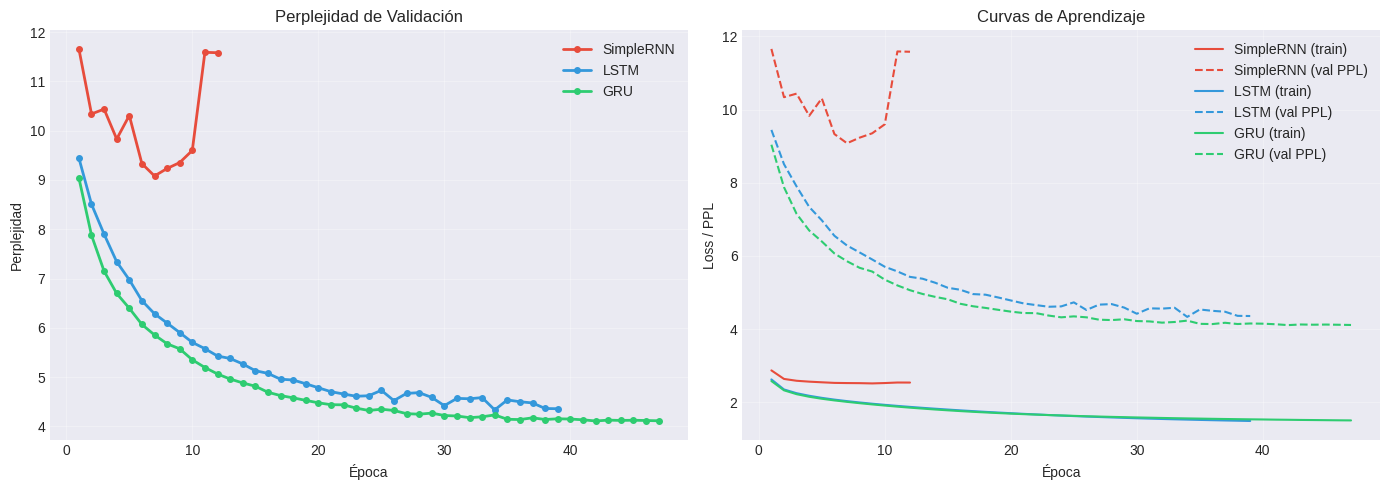


Resumen de Modelos:
  SimpleRNN : PPL = 9.08
  LSTM      : PPL = 4.33
  GRU       : PPL = 4.11


In [ ]:
colors = {'rnn': '#e74c3c', 'lstm': '#3498db', 'gru': '#2ecc71'}
labels_map = {'rnn': 'SimpleRNN', 'lstm': 'LSTM', 'gru': 'GRU'}

if histories:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Subplot 0: Perplexity de validación (solo cuando exista)
    for model_type, history in histories.items():
        val_ppl = history.history.get('val_perplexity', None)
        if val_ppl is None:
            val_loss = history.history.get('val_loss', None)
            if val_loss is not None:
                val_ppl = [float(np.exp(l)) for l in val_loss]
        if val_ppl:
            epochs_val = range(1, len(val_ppl) + 1)
            axes[0].plot(epochs_val, val_ppl, color=colors.get(model_type, None),
                         label=labels_map.get(model_type, model_type), linewidth=2,
                         marker='o', markersize=4)
    axes[0].set_xlabel('Época')
    axes[0].set_ylabel('Perplejidad')
    axes[0].set_title('Perplejidad de Validación')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Subplot 1: curvas de loss (train vs val)
    for model_type, history in histories.items():
        loss = history.history.get('loss', [])
        if loss:
            epochs_train = range(1, len(loss) + 1)
            axes[1].plot(epochs_train, loss, color=colors.get(model_type, None),
                         label=f"{labels_map.get(model_type, model_type)} (train)", linestyle='-')

        val_loss = history.history.get('val_loss', None)
        val_ppl = history.history.get('val_perplexity', None)
        if val_ppl:
            epochs_val = range(1, len(val_ppl) + 1)
            axes[1].plot(epochs_val, val_ppl, color=colors.get(model_type, None),
                         label=f"{labels_map.get(model_type, model_type)} (val PPL)", linestyle='--')
        elif val_loss:
            epochs_val = range(1, len(val_loss) + 1)
            axes[1].plot(epochs_val, val_loss, color=colors.get(model_type, None),
                         label=f"{labels_map.get(model_type, model_type)} (val loss)", linestyle='--')

    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Loss / PPL')
    axes[1].set_title('Curvas de Aprendizaje')

    handles, labels = axes[1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[1].legend(by_label.values(), by_label.keys())
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nResumen de Modelos:")
    print("=" * 55)
    for model_type, history in histories.items():
        val_ppl = history.history.get('val_perplexity', None)
        if val_ppl:
            best_ppl = min(val_ppl)
        else:
            val_loss = history.history.get('val_loss', None)
            if val_loss:
                best_ppl = float(np.exp(min(val_loss)))
            else:
                best_ppl = np.inf
        if np.isfinite(best_ppl):
            print(f"  {labels_map.get(model_type, model_type):<10}: PPL = {best_ppl:.2f}")
        else:
            print(f"  {labels_map.get(model_type, model_type):<10}: PPL = N/A (sin datos de validación)")
    print("=" * 55)


## 4. Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.

In [ ]:
# Seleccionar mejor modelo
best_model_type = min(histories, key=lambda x: min(histories[x].history.get('val_perplexity', [np.inf])))

model = models[best_model_type]
best_ppl = min(histories[best_model_type].history.get('val_perplexity', [np.inf]))

print(f"Usando modelo: {best_model_type.upper()} (PPL: {best_ppl:.2f})")

Usando modelo: GRU (PPL: 4.11)


### Utils

In [ ]:
def greedy_search(model, seed_text, max_length, num_chars):
    """Genera texto usando búsqueda greedy."""
    generated_text = seed_text.lower()
    for _ in range(num_chars):
        tokens = [char2idx.get(ch, 0) for ch in generated_text[-max_length:]]
        if len(tokens) < max_length:
            tokens = [0] * (max_length - len(tokens)) + tokens
        #x = np.array([tokens], dtype=np.int32)
        x = pad_sequences([tokens], maxlen=max_length, padding='pre')
        logits = model.predict(x, verbose=0)
        next_char_idx = np.argmax(logits[0, -1, :])
        generated_text += idx2char[next_char_idx]
    return generated_text

In [ ]:
def sample_with_temperature(model, seed_text, max_length, num_chars, temperature=1.0):
    """Genera texto usando muestreo con temperatura."""
    generated_text = seed_text.lower()
    for _ in range(num_chars):
        tokens = [char2idx.get(ch, 0) for ch in generated_text[-max_length:]]
        if len(tokens) < max_length:
            tokens = [0] * (max_length - len(tokens)) + tokens
        #x = np.array([tokens], dtype=np.int32)
        x = pad_sequences([tokens], maxlen=max_length, padding='pre')

        logits = model.predict(x, verbose=0)
        logits_scaled = logits[0, -1, :] / temperature
        probs = tf.nn.softmax(logits_scaled).numpy()
        next_char_idx = np.random.choice(len(probs), p=probs)
        generated_text += idx2char[next_char_idx]
    return generated_text

In [ ]:
def beam_search_deterministic(model, seed_text, max_length, num_chars, beam_width=5):
    """Genera texto usando beam search determinístico."""
    seed_text = seed_text.lower()
    beams = [(seed_text, 0.0)]
    for _ in range(num_chars):
        all_candidates = []
        for text, score in beams:
            tokens = [char2idx.get(ch, 0) for ch in text[-max_length:]]
            if len(tokens) < max_length:
                tokens = [0] * (max_length - len(tokens)) + tokens
            #x = np.array([tokens], dtype=np.int32)
            x = pad_sequences([tokens], maxlen=max_length, padding='pre')

            logits = model.predict(x, verbose=0)
            log_probs = tf.nn.log_softmax(logits[0, -1, :]).numpy()
            top_indices = np.argsort(log_probs)[-beam_width:]
            for idx in top_indices:
                all_candidates.append((text + idx2char[idx], score + log_probs[idx]))
        all_candidates.sort(key=lambda x: x[1], reverse=True)
        beams = all_candidates[:beam_width]
    final_sequences = [(text, score / len(text)) for text, score in beams]
    final_sequences.sort(key=lambda x: x[1], reverse=True)
    return final_sequences[0][0], final_sequences

In [ ]:
def beam_search_stochastic(model, seed_text, max_length, num_chars, beam_width=5, temperature=1.0):
    """Genera texto usando beam search estocástico."""
    seed_text = seed_text.lower()
    beams = [(seed_text, 0.0)]
    for _ in range(num_chars):
        all_candidates = []
        for text, score in beams:
            tokens = [char2idx.get(ch, 0) for ch in text[-max_length:]]
            if len(tokens) < max_length:
                tokens = [0] * (max_length - len(tokens)) + tokens
            #x = np.array([tokens], dtype=np.int32)
            x = pad_sequences([tokens], maxlen=max_length, padding='pre')

            logits = model.predict(x, verbose=0)
            logits_scaled = logits[0, -1, :] / temperature
            probs = tf.nn.softmax(logits_scaled).numpy()
            log_probs = np.log(probs + 1e-10)
            sampled_indices = np.random.choice(len(probs), size=min(beam_width, len(probs)),
                                               replace=False, p=probs)
            for idx in sampled_indices:
                all_candidates.append((text + idx2char[idx], score + log_probs[idx]))
        all_candidates.sort(key=lambda x: x[1], reverse=True)
        beams = all_candidates[:beam_width]
    final_sequences = [(text, score / len(text)) for text, score in beams]
    final_sequences.sort(key=lambda x: x[1], reverse=True)
    return final_sequences[0][0], final_sequences

### Análisis

In [ ]:
# Ejemplos de generación
seed = "ulises dijo"
print("="*70)
print(f"COMPARACIÓN DE MÉTODOS - Semilla: '{seed}'")
print("="*70)

print("\nGREEDY:")
print(greedy_search(model, seed, MAX_CONTEXT_SIZE, 100))

print("\nBEAM SEARCH (width=5):")
result, _ = beam_search_deterministic(model, seed, MAX_CONTEXT_SIZE, 100, 5)
print(result)

print("\nBEAM STOCHASTIC (width=5, T=0.1):")
result, _ = beam_search_stochastic(model, seed, MAX_CONTEXT_SIZE, 100, 5, 0.1)

print(result)

COMPARACIÓN DE MÉTODOS - Semilla: 'ulises dijo'

GREEDY:
ulises dijo en el palacio y le habló de esta manera: —¡oh, padre! no se le habló de esta manera: —¡oh, padre! n

BEAM SEARCH (width=5):
ulises dijo. así se expresó antínoo, habló de esta manera: —¡oh, dioses! no sea que se hallaba el arco y el div

BEAM STOCHASTIC (width=5, T=0.1):
ulises dijo a la una de las manos de la labra de la casa ánimo de la patria tierra. contestóle el prudente telé


In [ ]:
seed = "un amanecer lejano"
print("="*70)
print(f"EFECTO DE LA TEMPERATURA - Semilla: '{seed}'")
print("="*70)

for temp in [0.1, 0.2, 0.5, 0.8, 1.0, 1.5]:
    print(f"\nT = {temp}:")
    print(beam_search_stochastic(model, seed, MAX_CONTEXT_SIZE, 80, 5, temp))


EFECTO DE LA TEMPERATURA - Semilla: 'un amanecer lejano'

T = 0.1:
('un amanecer lejano en hablar de esta suerte: —¡oh, amigos! v. 360 respondióle el ingenioso odiseo:', [('un amanecer lejano en hablar de esta suerte: —¡oh, amigos! v. 360 respondióle el ingenioso odiseo:', np.float32(-0.3112842)), ('un amanecer lejano en hablar de esta suerte: —¡oh, amigos! v. 360 respondióle el prudente telémaco', np.float32(-0.33033913)), ('un amanecer lejano en hablar de esta suerte: —¡oh, amigos! la discreta penelopea, le dijo estas pa', np.float32(-0.3855007)), ('un amanecer lejano en hablar de esta suerte: —¡oh, amigos! v. 360 respondióle el ingenioso odiseo ', np.float32(-0.39478737)), ('un amanecer lejano en hablar de esta suerte: —¡oh, amigos! v. 360 respondióle el ingenioso odiseo)', np.float32(-0.3989859))])

T = 0.2:
('un amanecer lejano único junto a la . zeusjo ánimo de zeus de zeus? ¿quién grande fuerzas retorcid', [('un amanecer lejano único junto a la . zeusjo ánimo de zeus de zeus? ¿q

In [ ]:
seed = "el héroe regresó"
print("="*70)
print(f"EFECTO DE LA TEMPERATURA - Semilla: '{seed}'")
print("="*70)

for temp in [0.1, 0.2, 0.5, 0.8, 1.0, 1.5]:
    print(f"\nT = {temp}:")
    print(beam_search_stochastic(model, seed, MAX_CONTEXT_SIZE, 80, 5, temp))


EFECTO DE LA TEMPERATURA - Semilla: 'el héroe regresó'

T = 0.1:
('el héroe regresó a la discreta penelopea: —¡oh, manos de esta suerte: —¡oh, compañeros junto a l', [('el héroe regresó a la discreta penelopea: —¡oh, manos de esta suerte: —¡oh, compañeros junto a l', np.float32(-0.3460267)), ('el héroe regresó a la discreta penelopea: —¡oh, manos de esta suerte: —¡oh, compañeros en su pal', np.float32(-0.39097917)), ('el héroe regresó a la discreta penelopea: —¡oh, manos de esta suerte: —¡oh, compañeros junto a c', np.float32(-0.3982711)), ('el héroe regresó a la discreta penelopea: —¡oh, manos de esta suerte: —¡oh, compañeros en la sal', np.float32(-0.398445)), ('el héroe regresó a la discreta penelopea: —¡oh, manos de esta suerte: —¡oh, compañeros junto a q', np.float32(-0.39860895))])

T = 0.2:
('el héroe regresó odiseo2 así se expresó1 no hable de esta 6anera— —¡eurímaco! que , cuando así f', [('el héroe regresó odiseo2 así se expresó1 no hable de esta 6anera— —¡eurímaco! que , cua

In [ ]:
# Guardar modelo
model.save('best_char_lm_keras.keras')

#### Greedy Search

* Es determinístico. Siempre produce el mismo resultado para la misma semilla.
* Es muy rápido porque solo elige el más probable en cada paso.
* Pierde coherencia la frase porque tiene tendencia a responder loops.
* Mantiene estructura gramatical.
* Usa frases del corpus frecuentemente (Ej: "—¡oh, padre!").
* Es útil como baseline, pero su tendencia a repetirse lo hace inadecuado para generación de texto de calidad. El modelo "se atasca" en patrones de alta probabilidad.

#### Beam Search Determinístico

* Selecciona los mejores n beams y avanza al siguiente nivel repitiendo el proceso.
* Selecciona la secuencia con mejor score normalizado.
* Sigue siendo determinístico, aunque mejor que GREEDY.
* Tiene más coherencia que Greedy y explora mejores caminos
* Nombra a uno personajes del corpus, Antínoo.
* Tiene mejor transición entre frases.

* Mejora significativamente la calidad al considerar múltiples hipótesis simultáneas. El texto generado es más rico y variado que usando Greedy, y mantiene coherencia gramatical.

#### Beam Search Estocástico

* Muestrea k opciones según una probabilidad dada.
* Genera textos diferentes en cada ejecución.
* La temperatura permite ajustar creatividad.
* Tiene buena coherencia con T baja (0.1), pero se degrada rápidamente con T > 0.2.
* El muestreo aleatorio evita los loops de palabras.

**Efecto de la Temperatura:**

* T=0.1: Aparecen números, primeros errores.
* T=0.5: Texto incoherente, caracteres aleatorios.
* T=0.8-1.5: Texto completamente degradado.
* Para este modelo de caracteres con vocabulario pequeño, la temperatura óptima está entre 0.1 y 0.2. Valores mayores introducen demasiado ruido.

---

#### Comparación Final

| Método | Coherencia | Diversidad | Repetición | Recomendación |
|--------|:----------:|:----------:|:----------:|---------------|
| **Greedy** | Media | Baja | Alta | Solo para pruebas rápidas |
| **Beam Det.** | Alta | Baja | Baja | Cuando se necesita consistencia |
| **Beam Stoch. (T=0.1)** | Alta | Media | Muy baja | Mejor balance general |
| **Beam Stoch. (T≥0.5)** | Ninguna | Alta | Ninguna | No recomendado para este modelo |

---

#### Conclusiones

El modelo requiere temperaturas muy bajas. En modelos a nivel de palabra, temperaturas más altas (0.7-1.0) puede funcionar bien, pero los modelos de caracteres son más sensibles al ruido porque un error en un solo carácter puede arruinar palabras completas.

Beam Search supera consistentemente a Greedy. La exploración de múltiples ramas probables evita los loops y produce texto más natural y variado.

El muestreo estocástico aporta diversidad controlada. Con T=0.1, se obtiene variabilidad sin sacrificar coherencia, ideal para generar múltiples versiones de texto. Con una temperatura muy alta las palabras generadas dejan de tener significado y se vuelve incoherente.